# Probabilistic Machine Learning
#### University of Tübingen, Summer Term 2021
## Exercise Sheet 1
&copy; 2020 Prof. Dr. Philipp Hennig, Emilia Magnani & Lukas Tatzel

This sheet is **due on Tuesday 27 April 2021 at 10am sharp.**

---

## Deep Learning on the *Keeling curve*

In previous lecture courses you have become accustomed with various models of *Deep Learning*. In popular texts it can sometimes sound as if deep learning has made all other concepts of machine learning obsolete. The point of this exercise is to reflect on this sentiment. 

You will work with the famous [Keeling curve](https://www.esrl.noaa.gov/gmd/ccgg/trends/), a time series of atmospheric CO2 concentrations collected at the Mauna Loa observatory in Hawaii. Your task is to produce an extrapolation of this dataset from today 40 years into the future, using a deep learning framework. This notebook will download the data and train a basic neural network using [pytorch](https://pytorch.org/). 

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

import pandas as pd
import torch
import torch.nn as nn

### 1) Load Data

As a first step, let's load the CO2 data into a pandas dataframe.

In [2]:
# URL for monthly mean data
url = 'ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_mm_mlo.txt'

# Read CSV data from url
data = pd.read_csv(url, 
                   delim_whitespace=True, 
                   header=52,
                   usecols=[0, 1, 2, 3],
                   names=['Year', 'Month', 'DecimalDate', 'CO2_av'])
display(data)

,Year,Month,DecimalDate,CO2_av
0,1958,3,1958.2027,315.70
1,1958,4,1958.2877,317.45
2,1958,5,1958.3699,317.51
3,1958,6,1958.4548,317.24
4,1958,7,1958.5370,315.86
...,...,...,...,...
752,2020,11,2020.8750,413.11
753,2020,12,2020.9583,414.25
754,2021,1,2021.0417,415.52
755,2021,2,2021.1250,416.75


### 2) Split Data

Now, we split the data into training and test data.

In [3]:
# Convert to pytorch column "vectors"
X = torch.FloatTensor(data['DecimalDate'].values).reshape(-1, 1)
Y = torch.FloatTensor(data['CO2_av']).reshape(-1, 1)

# Use the last TEST_LENGTH months for testing, the rest for training
TEST_LENGTH = 3 * 12

# Training data
X_train = X[:-TEST_LENGTH]
Y_train = Y[:-TEST_LENGTH]

# Test data
X_test  = X[-TEST_LENGTH:]
Y_test  = Y[-TEST_LENGTH:]

# Data for prediction
PRED_LENGTH = 40 * 12
X_pred = (X[-1] + torch.arange(1, PRED_LENGTH + 1) / 12.0).reshape(-1, 1)

### 3) Preprocess Data

Let's normalize our data. 

In [4]:
def apply_transform(data_list, shift, scale):
    """Return list of normalized data"""
    
    return [(data - shift) / scale for data in data_list]


# Normalize X data
X_shift = X_train.mean()
X_scale = X_train.std()
X_norm  = apply_transform([X_train, X_test, X_pred], 
                          shift=X_shift, scale=X_scale)
[X_train_norm, X_test_norm, X_pred_norm] = X_norm

# Normalize Y data
Y_shift = Y_train.mean()
Y_scale = Y_train.std()
Y_norm  = apply_transform([Y_train, Y_test], 
                          shift=Y_shift, scale=Y_scale)
[Y_train_norm, Y_test_norm] = Y_norm

In [59]:
col_train = '#327bb3' # blue
col_test  = '#b04f4f' # red
col_pred  = '#4fb062' # green

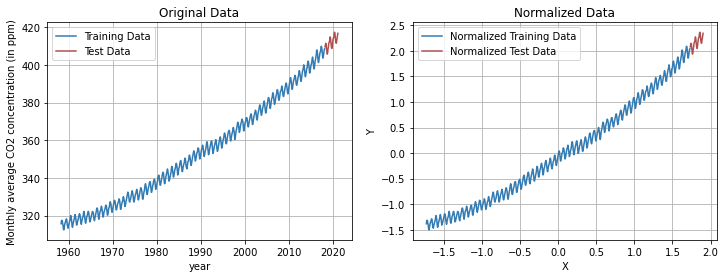

In [6]:
# Visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Subplot 1: Original data
ax = axs[0]
ax.plot(X_train, Y_train, 
        color=col_train, label='Training Data')
ax.plot(X_test,  Y_test,  
        color=col_test, label='Test Data')
ax.set_xlabel('year')
ax.set_ylabel('Monthly average CO2 concentration (in ppm)')
ax.set_title('Original Data')
ax.grid()
ax.legend()

# Subplot 2: Normalized data
ax = axs[1]
ax.plot(X_train_norm, Y_train_norm, 
        color=col_train, label='Normalized Training Data')
ax.plot(X_test_norm,  Y_test_norm,  
        color=col_test,  label='Normalized Test Data')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Normalized Data')
ax.grid()
ax.legend()

plt.show()

### 4) Train the Neural Network

Define the model architecture, the loss function and the optimizer. Use the normalized data to train the neural network for a given number of epochs.

In [7]:
# Set seed value for reproducibility
torch.manual_seed(0)

# Compute on GPU, if available
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Choose neural network architecture
model = nn.Sequential(
    nn.Linear(1, 100),
    nn.ReLU(),
    nn.Linear(100, 1)
).to(DEVICE)
print(f'Network nof_parameters = {sum(p.numel() for p in model.parameters())}\n')

# Choose loss function (suitable for regression tasks)
loss_func = torch.nn.MSELoss()

# Choose optimizer and hyperparameters
optimizer = torch.optim.Adam(model.parameters())

# Train for NOF_EPOCHS epochs
NOF_EPOCHS = 500

print('Training Progress...')
for epoch in range(NOF_EPOCHS):
    
    model.train()
    
    # Forward pass
    inputs, labels = X_train_norm.to(DEVICE), Y_train_norm.to(DEVICE)
    outputs = model(inputs)
    train_loss = loss_func(outputs, labels)
    
    # Zero the parameter gradients, backward pass, optimize
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    
    # Print progress
    if epoch % (NOF_EPOCHS / 10) == 0:
        
        model.eval()
        
        with torch.no_grad():
            
            # Forward pass on test data
            inputs, labels = X_test_norm.to(DEVICE), Y_test_norm.to(DEVICE)
            outputs   = model(inputs)
            test_loss = loss_func(outputs, labels)
            
            print(  f'Epoch {epoch:4};    '
                  + f'Training Loss: {train_loss.item():.3f};    '
                  + f'Test Loss: {test_loss.item():.3f}')
        

Network nof_parameters = 301

Training Progress...
Epoch    0;    Training Loss: 1.344;    Test Loss: 6.862
Epoch   50;    Training Loss: 0.049;    Test Loss: 0.231
Epoch  100;    Training Loss: 0.019;    Test Loss: 0.063
Epoch  150;    Training Loss: 0.009;    Test Loss: 0.023
Epoch  200;    Training Loss: 0.007;    Test Loss: 0.013
Epoch  250;    Training Loss: 0.007;    Test Loss: 0.011
Epoch  300;    Training Loss: 0.007;    Test Loss: 0.011
Epoch  350;    Training Loss: 0.007;    Test Loss: 0.012
Epoch  400;    Training Loss: 0.007;    Test Loss: 0.012
Epoch  450;    Training Loss: 0.006;    Test Loss: 0.012


### 5) Evaluate Trained Model

Let's explore the model extraplolation.

In [8]:
# Evaluate trained model
model.eval()
model.to('cpu')
with torch.no_grad():
    Y_train_predict = model(X_train_norm) * Y_scale + Y_shift
    Y_test_predict  = model(X_test_norm)  * Y_scale + Y_shift
    Y_pred_predict  = model(X_pred_norm)  * Y_scale + Y_shift

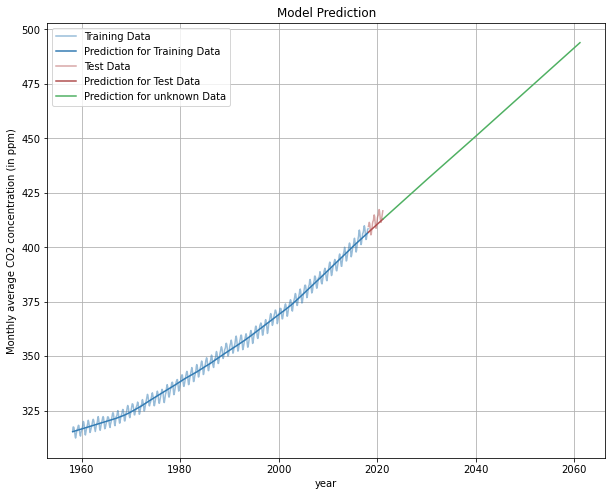

In [9]:
# Visualization 
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Training data
ax.plot(X_train, Y_train, 
        color=col_train, label='Training Data', alpha=0.5)
ax.plot(X_train, Y_train_predict, 
        color=col_train, label='Prediction for Training Data')

# Test data
ax.plot(X_test,  Y_test,  
        color=col_test, label='Test Data', alpha=0.5)
ax.plot(X_test, Y_test_predict,
        color=col_test, label='Prediction for Test Data')

# Pred data
ax.plot(X_pred, Y_pred_predict, 
       color=col_pred, label='Prediction for unknown Data')

# General plot settings
ax.set_xlabel('year')
ax.set_ylabel('Monthly average CO2 concentration (in ppm)')
ax.set_title('Model Prediction')
ax.grid()
ax.legend()
plt.show()

### Your Tasks

First, provide answers to the following two questions. 

**(1) Are you happy with the extrapolation? Why/why not?** 

**Answer:** No, for three reasons. First, there is obvious yearly periodicity in the data, which is completely ignored by the prediction. Second, the extrapolation seems to grow linearly. In the data, it seems more like exponential growth to me. Third, it is not physically possible for the CO2-concentration to grow indefinitely as would probably be predicted by the model.

---

**(2) Do you trust the extrapolation? Why/why not?** 

**Answer:** No, for the reasons listed above.

---

**Task**: Your task is to come up with your own solution using a deep learning framework of your choice. First, develop an alternative concept to compute the extrapolation. Write down your idea and briefly describe why and in what way your approach is expected to be an improvement compared to the extrapolation above. A few lines of text should be enough. Note however, that e.g. just adding layers and changing the optimizer won't be regarded as "sufficient". We want to see that you really put some thought into your concept. 

**Your concept:**
Two ideas:
1. If the output of the neural network is $(a, b, c, d, e, f)$, let the actual prediction be $h(t) = a + b\exp(ct) + d \sin(e t + f)$. This should address the first two problems mentioned above. The network has to be optimized with respect to the actual prediction $h(t)$, of course. Of course, now $a$ - $f$ are just parameters that need to be found. In the implementation a neural network is used, but it is always called with the input $1.0$ such that $a$ - $f$ are not dependent on the time, that is what $h(t)$ is for.

---

**Task**: Actually implement your idea. You can use the above code as a template. Of course, you are free to re-organize the data, modify the network architecture, the optimizer, loss function etc. You can also use a different framework than pytorch, if you want.

# First idea

In [169]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = nn.Sequential(
            nn.Linear(1, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 6)
        )

    def forward(self, t):
        a, b, c, d, e, f = self.base(torch.as_tensor([[1.]])).T
        h = a + b*torch.exp(c * t.T) + d*torch.sin(e*t.T + f)
        return h.T
    
    def loss(self, target):
        pred = model(X_train_norm)
        a, b, c, d, e, f = self.base(torch.as_tensor([[1.]])).T
        return (F.mse_loss(pred, target) 
                + 100/torch.abs(e[0])      # Larger frequency
                - 0.1*torch.tanh(d[0])     # Nonzero amplitude
                - 0.1*torch.tanh(b[0])     # Positive b
                - 0.1*torch.tanh(c[0]))    # Positive c

In [38]:
import torch.nn.functional as F

In [170]:
model = Model()
optim = torch.optim.Adam(model.parameters())

for epoch in range(5000):
    optim.zero_grad()
    loss = model.loss(Y_train_norm)
    loss.backward()
    optim.step()
    if epoch % 100 == 0:
        a, b, c, d, e, f = model.base(torch.as_tensor([[1.]])).T
        print(f"Epoch {epoch:3d}, Training Loss = {loss:.4f}, frequency = {e[0]:.4f}, amplitude = {d[0]:.4f}")

Epoch   0, Training Loss = 2101.0332, frequency = 0.1391, amplitude = -0.0096
Epoch 100, Training Loss = 90.3801, frequency = 1.1108, amplitude = 0.7709
Epoch 200, Training Loss = 53.3111, frequency = 1.8787, amplitude = 0.4358
Epoch 300, Training Loss = 35.8591, frequency = 2.7870, amplitude = 0.2630
Epoch 400, Training Loss = 26.6367, frequency = 3.7455, amplitude = 0.0937
Epoch 500, Training Loss = 21.0532, frequency = 4.7303, amplitude = 0.1067
Epoch 600, Training Loss = 17.3407, frequency = 5.7325, amplitude = 0.1256
Epoch 700, Training Loss = 14.7033, frequency = 6.7494, amplitude = 0.1320
Epoch 800, Training Loss = 12.7374, frequency = 7.7805, amplitude = 0.1047
Epoch 900, Training Loss = 11.2083, frequency = 8.8284, amplitude = 0.1061
Epoch 1000, Training Loss = 9.9862, frequency = 9.8932, amplitude = 0.1078
Epoch 1100, Training Loss = 5.8483, frequency = 16.8396, amplitude = 0.0973
Epoch 1200, Training Loss = 3.6055, frequency = 26.8412, amplitude = 0.1040
Epoch 1300, Training

In [172]:
# Evaluate trained model
model.eval()
model.to('cpu')
with torch.no_grad():
    Y_train_predict = model(X_train_norm) * Y_scale + Y_shift
    Y_test_predict  = model(X_test_norm)  * Y_scale + Y_shift
    Y_pred_predict  = model(X_pred_norm)  * Y_scale + Y_shift

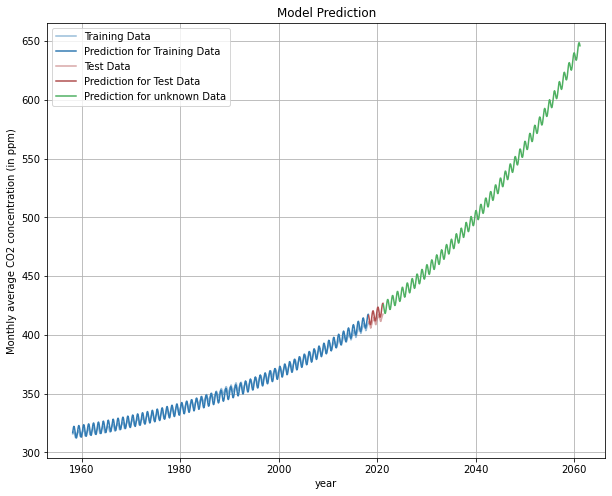

In [173]:
# Visualization 
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Training data
ax.plot(X_train, Y_train, 
        color=col_train, label='Training Data', alpha=0.5)
ax.plot(X_train, Y_train_predict, 
        color=col_train, label='Prediction for Training Data')

# Test data
ax.plot(X_test,  Y_test,  
        color=col_test, label='Test Data', alpha=0.5)
ax.plot(X_test, Y_test_predict,
        color=col_test, label='Prediction for Test Data')

# Pred data
ax.plot(X_pred, Y_pred_predict, 
       color=col_pred, label='Prediction for unknown Data')

# General plot settings
ax.set_xlabel('year')
ax.set_ylabel('Monthly average CO2 concentration (in ppm)')
ax.set_title('Model Prediction')
ax.grid()
ax.legend()
plt.show()